## **Import**

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import cv2
import time
import json
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
if tf.__version__ <= "2.3.0":
    from tensorflow.keras.models import Model
    from tensorflow.keras import layers
    from tensorflow.keras import optimizers
    from tensorflow.keras import losses
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
    # Import pretrained models
    from tensorflow.keras.applications import ResNet50V2,VGG16, InceptionV3, MobileNetV2, DenseNet121
else:

    from keras.models import Model
    from keras import layers
    from keras import optimizers
    from keras import losses
    from keras.utils import to_categorical
    from keras.callbacks import EarlyStopping, ModelCheckpoint
    # Import pretrained models
    from keras.applications import ResNet50V2,VGG16, InceptionV3, MobileNetV2, DenseNet121

from sklearn.model_selection import train_test_split

In [2]:
# https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)

tensorflow version 2.10.1
keras version 2.10.0


## **Dog DataSet**

In [7]:
!rm -rf DatasetStore

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [8]:
# import requests
# import tarfile
# dataset_path = "DatasetStore"
# 
# # Download and extract dataset
# if not os.path.exists(dataset_path):
#   os.mkdir(dataset_path)
#   packet_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
#   packet_file = os.path.basename(packet_url)
#   packet_file = os.path.join(dataset_path, packet_file)
#   with requests.get(packet_url, stream=True) as r:
#       r.raise_for_status()
#       with open(packet_file, 'wb') as f:
#           for chunk in r.iter_content(chunk_size=8192):
#               f.write(chunk)
# 
#   with tarfile.open(packet_file) as tfile:
#     tfile.extractall(dataset_path)
# 
#   packet_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar"
#   packet_file = os.path.basename(packet_url)
#   packet_file = os.path.join(dataset_path, packet_file)
#   with requests.get(packet_url, stream=True) as r:
#       r.raise_for_status()
#       with open(packet_file, 'wb') as f:
#           for chunk in r.iter_content(chunk_size=8192):
#               f.write(chunk)
# 
#   with tarfile.open(packet_file) as tfile:
#     tfile.extractall(dataset_path)

**Load data**

In [4]:
import pickle
breed_list = os.listdir('../Dog_Breed_Dataset/Dogs/') # list of all breeds for further demo
breed_list.sort()

# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(breed_list))
index2label = dict((index, name) for index, name in enumerate(breed_list))
with open('label2index_tsinghua.pickle', 'wb') as f:
    pickle.dump(label2index, f)

images = []
annotations =[]
for breed in breed_list:
  image_files = os.listdir('../Dog_Breed_Dataset/Dogs_rebalanced/' + breed)
  image_files.sort()
  images.extend([os.path.join('../Dog_Breed_Dataset/Dogs_rebalanced/',breed,f) for f in image_files])
  annotations.extend([os.path.join('../Dog_Breed_Dataset/',breed,f.replace(".jpg","")).replace("\\","/") for f in image_files])

for idx, ann in enumerate(annotations):
    annotations[idx] = ann.split("/")[2] # add dog breed name

# Prepare train test validate datasets
Xs = np.asarray(images)
Ys = np.asarray(annotations)

# Split into train_validate + test data
train_validate_x,test_x, train_validate_y, test_y = train_test_split(Xs,Ys,test_size=0.1)

## **Build Data Generator**

In [5]:
validation_percent = 0.2
image_width = 128
image_height = 128
num_channels = 3
num_classes = len(breed_list)

epochs = 50
train_batch_size = 32
validation_batch_size = 32
test_batch_size = 32
train_shuffle_size = train_batch_size * 3
validation_shuffle_size = validation_batch_size * 3
# Split data into train / validation
train_x, validate_x, train_y, validate_y = train_test_split(train_validate_x, train_validate_y, test_size=validation_percent)

#  Converts to binary class matrix (One-hot-encoded)

train_processed_y = np.asarray([label2index[label] for label in train_y])
validate_processed_y = np.asarray([label2index[label] for label in validate_y])
test_processed_y = np.asarray([label2index[label] for label in test_y])
train_processed_y = to_categorical(train_processed_y, num_classes=num_classes, dtype='float32')
validate_processed_y = to_categorical(validate_processed_y, num_classes=num_classes, dtype='float32')
test_processed_y = to_categorical(test_processed_y, num_classes=num_classes, dtype='float32')

train_data_count = train_x.shape[0]
steps_per_epoch = int(train_data_count // train_batch_size)
validation_data_count = validate_x.shape[0]
validation_steps = int(validation_data_count // validation_batch_size)

# Prepare the data
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=num_channels)
    image = tf.image.resize(image,[image_height,image_width])
    return image, label

# Normalize pixels
def normalize(image, label):
    image = image/255
    return image, label

def build_data_generators(train_data_process_list=[load_image,normalize],validate_data_process_list=[load_image,normalize],test_data_process_list=[load_image,normalize]):

    # Create TF Dataset
    train_data = tf.data.Dataset.from_tensor_slices((train_x.tolist(), train_processed_y.tolist()))
    validation_data = tf.data.Dataset.from_tensor_slices((validate_x.tolist(), validate_processed_y.tolist()))
    test_data = tf.data.Dataset.from_tensor_slices((test_x.tolist(), test_processed_y.tolist()))


    # Train data
    # Shuffle
    train_data = train_data.shuffle(train_data_count)
    # Apply all data processing logic
    for process in train_data_process_list:
        train_data = train_data.map(process, num_parallel_calls=AUTOTUNE)

    train_data = train_data.repeat(epochs).batch(train_batch_size)

    # Validation data
    # Shuffle
    validation_data = validation_data.shuffle(validation_data_count)
    # Apply all data processing logic
    for process in validate_data_process_list:
        validation_data = validation_data.map(process, num_parallel_calls=AUTOTUNE)

    validation_data = validation_data.repeat(epochs).batch(validation_batch_size)

    # Test data
    # Apply all data processing logic
    for process in test_data_process_list:
        test_data = test_data.map(process, num_parallel_calls=AUTOTUNE)
    test_data = test_data.repeat(1).batch(test_batch_size)

    return train_data, validation_data, test_data

train_data, validation_data, test_data = build_data_generators()
print("train_data",train_data)
print("validation_data",validation_data)
print("test_data",test_data)

train_data <BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 131), dtype=tf.float32, name=None))>
validation_data <BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 131), dtype=tf.float32, name=None))>
test_data <BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 131), dtype=tf.float32, name=None))>


## **Utility Function**

In [6]:
import decimal

class JsonEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, decimal.Decimal):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(JsonEncoder, self).default(obj)

def get_model_metrics():
    with open("./SavedModels/tsinghuamodel_metrics.json") as json_file:
        model_metrics = json.load(json_file)

    return model_metrics

def save_model_metrics(model_name="model_1",metrics={}):
    if os.path.exists("./SavedModels/sub500tsinghuamodel_metrics.json"):
        with open("./SavedModels/sub500tsinghuamodel_metrics.json") as json_file:
            model_metrics = json.load(json_file)
    else:
        model_metrics = {}

    model_metrics[model_name] = metrics

    # Save the json
    with open("./SavedModels/sub500tsinghuamodel_metrics.json", 'w') as json_file:
        json_file.write(json.dumps(model_metrics, cls=JsonEncoder))

def save_model(path="./SavedModels",model_name="model01"):
    filename = "./SavedModels/"
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    # Save the enitire model (structure + weights)
    model.save(os.path.join(path,model_name+".hdf5"))

    # Save only the weights
    model.save_weights(os.path.join(path,model_name+".h5"))

    # Save the structure only
    model_json = model.to_json()
    with open(os.path.join(path,model_name+".json"), "w") as json_file:
        json_file.write(model_json)

def get_model_size(path="./SavedModels",model_name="model01"):
    model_size = os.stat(os.path.join(path,model_name+".hdf5")).st_size
    return model_size

def evaluate_save_model(model,training_results,test_data,execution_time, learning_rate, batch_size, epochs, optimizer,momentum = None, save=True):

    # Get the model train history
    model_train_history = training_results.history
    # Get the number of epochs the training was run for
    num_epochs = len(model_train_history["loss"])

    # Plot training results
    fig = plt.figure(figsize=(15,5))
    axs = fig.add_subplot(1,2,1)
    axs.set_title('Loss')
    # Plot all metrics
    for metric in ["loss","val_loss"]:
        axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
    axs.legend()

    axs = fig.add_subplot(1,2,2)
    axs.set_title('Accuracy')
    # Plot all metrics
    for metric in ["accuracy","val_accuracy"]:
        axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
    axs.legend()

    plt.show()

    # Evaluate on test data
    evaluation_results = model.evaluate(test_data)
    print('Evaluation results: [loss, accuracy]', evaluation_results)

    if save:
        # Save model
        save_model(model_name=model.name)
        model_size = get_model_size(model_name=model.name)

        # Save model history
        with open(os.path.join("./SavedModels","tsinghua"+model.name+"_train_history.json"), "w") as json_file:
            json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

        trainable_parameters = model.count_params()

        # Save model metrics
        metrics ={
            "trainable_parameters":trainable_parameters,
            "execution_time":execution_time,
            "loss":evaluation_results[0],
            "accuracy":evaluation_results[1],
            "model_size":model_size,
            "learning_rate":learning_rate,
            "batch_size":batch_size,
            'momentum': momentum,
            "epochs":epochs,
            "optimizer":type(optimizer).__name__
        }
        save_model_metrics(model_name=model.name,metrics=metrics)

Compare all models

In [19]:
# Compare model metrics
view_metrics = pd.read_json("./SavedModels/sub500_tsinghuamodel_metrics.json")
view_metrics = view_metrics.T
# Format columns
view_metrics['accuracy'] = view_metrics['accuracy']*100
view_metrics['accuracy'] = view_metrics['accuracy'].map('{:,.2f}%'.format)

view_metrics['trainable_parameters'] = view_metrics['trainable_parameters'].map('{:,.0f}'.format)
view_metrics['execution_time'] = view_metrics['execution_time'].map('{:,.2f} mins'.format)
#view_metrics['loss'] = view_metrics['loss'].map('{:,.2f}'.format)
view_metrics['model_size'] = view_metrics['model_size']/1000000
view_metrics['model_size'] = view_metrics['model_size'].map('{:,.0f} MB'.format)
print('Number of models:',view_metrics.shape[0])

FileNotFoundError: File ./SavedModels/sub500_tsinghuamodel_metrics.json does not exist

## **VGG16**
Use VGG16 as the base and fine tune the last conv2d block for our problem

### Build model

In [7]:
# vgg16 with fine tuning the last conv2d base
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(image_height,image_width,3))

def view_layers(model):
    layers = model.layers
    layers_list = []

    for idx, layer in enumerate(layers):
        layers_list.append({
            'layer': type(layer).__name__,
            'trainable':layer.trainable
        })

    df = pd.DataFrame(layers_list)

    return df

layers_df = view_layers(vgg16)


### Training params

In [8]:
############################
# Training Params
############################
learning_rate = 0.001
batch_size = 32
epochs = 50
############################


# Set all layers as trainable false execpt last conv block
for layer in vgg16.layers[:-4]:
    layer.trainable = False

# Input
model_input = vgg16.layers[0].input

# Final pool layer
hidden = vgg16.layers[-1]
print("Pool Layer",hidden)

# Flatten
hidden = layers.Flatten()(hidden.output)

#  Hidden Layer, Classification Block
hidden = layers.Dense(units=1024, activation='relu')(hidden)
hidden = layers.Dense(units=1024, activation='relu')(hidden)

# Output Layer
output = layers.Dense(units=num_classes, activation='softmax')(hidden)

# Build model
model = Model(model_input, output, name='sub500_VGG16')

# Optimizer
optimizer = optimizers.SGD(learning_rate=learning_rate)

# Loss
loss = losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

#print(model.summary())
layers_df = view_layers(model)

Pool Layer <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000015B23A21660>


### Train model

In [9]:
# Train model

# Early Stopping
earlystopping = EarlyStopping(monitor='val_accuracy', patience=10)

# Model Checkpoint
checkpoint_filepath = './Checkpoints/checkpoint_VGG16'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)


start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        callbacks=[earlystopping,model_checkpoint_callback],
        epochs=epochs,
        verbose=1,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)


Epoch 1/50
1154/1155 [============================>.] - ETA: 0s - loss: 4.7724 - accuracy: 0.0255
Epoch 1: val_accuracy improved from -inf to 0.05577, saving model to ./Checkpoints\checkpoint_VGG16
1155/1155 [==============================] - 61s 48ms/step - loss: 4.7723 - accuracy: 0.0255 - val_loss: 4.5420 - val_accuracy: 0.0558
Epoch 2/50
1154/1155 [============================>.] - ETA: 0s - loss: 3.9608 - accuracy: 0.1176
Epoch 2: val_accuracy improved from 0.05577 to 0.16330, saving model to ./Checkpoints\checkpoint_VGG16
1155/1155 [==============================] - 52s 45ms/step - loss: 3.9602 - accuracy: 0.1177 - val_loss: 3.5285 - val_accuracy: 0.1633
Epoch 3/50
1155/1155 [==============================] - ETA: 0s - loss: 3.0988 - accuracy: 0.2412
Epoch 3: val_accuracy improved from 0.16330 to 0.25998, saving model to ./Checkpoints\checkpoint_VGG16
1155/1155 [==============================] - 53s 46ms/step - loss: 3.0988 - accuracy: 0.2412 - val_loss: 2.9768 - val_accuracy: 0.

### Evaluate and Save

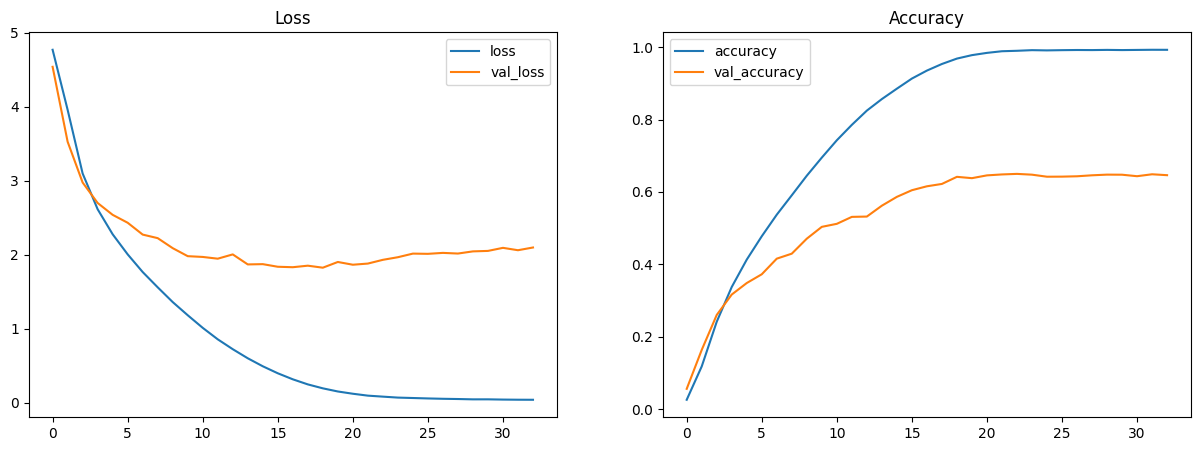

161/161 [==============================] - 5s 29ms/step - loss: 1.9457 - accuracy: 0.6567
Evaluation results: [loss, accuracy] [1.9457461833953857, 0.6567367315292358]


In [10]:
# Evaluate and Save model
evaluate_save_model(model,training_results,test_data,execution_time, learning_rate, batch_size, epochs, optimizer)

## **ResNet50V2 with Adam optimizer**

In [11]:
resnet50_v2 = ResNet50V2(
    include_top=False,
    input_shape=(128, 128, 3)
)

### Build model

In [12]:
# Build model for Resnet
def build_resnet_model(model_name = 'sub500_ResNet50V2',print_summary=True):
  # Set all layers as hidden
  for layer in resnet50_v2.layers:
      layer.trainable = False

  # Input
  model_input = resnet50_v2.layers[0].input

  # Extract final pool layer
  hidden = resnet50_v2.layers[-1]

  # Flatten
  hidden = layers.Flatten()(hidden.output)

  # Output Layer
  output = layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = Model(model_input, output, name=model_name)

  # Print the model architecture
  if print_summary:
    print(model.summary())

  return model

### Training params

In [13]:
############################
# Training Params
############################
batch_size = 32
epochs = 50
############################

# Early Stopping
earlystopping = EarlyStopping(monitor='val_accuracy', patience=10)

# Model Checkpoint
checkpoint_filepath = './Checkpoints/checkpoint_ResNet50V2'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)

# Build the model
model = build_resnet_model(print_summary=False)

# Optimier
optimizer = optimizers.Adam()

# Loss
loss = losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])




### Train model

In [14]:
# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=[earlystopping,model_checkpoint_callback],
        verbose=1,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)



Epoch 1/50
1155/1155 [==============================] - ETA: 0s - loss: 24.6653 - accuracy: 0.4195
Epoch 1: val_accuracy improved from -inf to 0.51009, saving model to ./Checkpoints\checkpoint_ResNet50V2
1155/1155 [==============================] - 46s 37ms/step - loss: 24.6653 - accuracy: 0.4195 - val_loss: 24.1221 - val_accuracy: 0.5101
Epoch 2/50
1155/1155 [==============================] - ETA: 0s - loss: 9.8084 - accuracy: 0.7242
Epoch 2: val_accuracy improved from 0.51009 to 0.56814, saving model to ./Checkpoints\checkpoint_ResNet50V2
1155/1155 [==============================] - 41s 36ms/step - loss: 9.8084 - accuracy: 0.7242 - val_loss: 25.0035 - val_accuracy: 0.5681
Epoch 3/50
1155/1155 [==============================] - ETA: 0s - loss: 6.4588 - accuracy: 0.8174
Epoch 3: val_accuracy improved from 0.56814 to 0.58160, saving model to ./Checkpoints\checkpoint_ResNet50V2
1155/1155 [==============================] - 41s 36ms/step - loss: 6.4588 - accuracy: 0.8174 - val_loss: 29.106

### Evaluate and Save

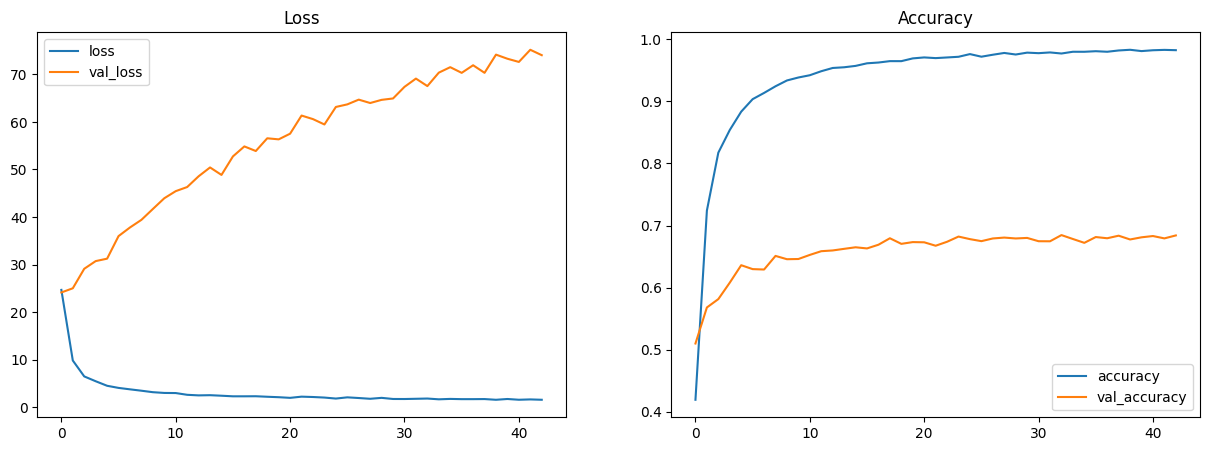

161/161 [==============================] - 4s 27ms/step - loss: 71.4913 - accuracy: 0.6918
Evaluation results: [loss, accuracy] [71.49128723144531, 0.6917834877967834]


In [15]:
# Evaluate and Save model
learning_rate = 0.001
evaluate_save_model(model,training_results,test_data,execution_time, learning_rate, batch_size, epochs, optimizer)

## Add data augmentation to ResNet50V2

In [16]:
# Create data augmentation processors

# https://www.tensorflow.org/api_docs/python/tf/image/adjust_brightness
def adjust_brightness(image, label):
    return tf.image.adjust_brightness(image, 0.01), label

# https://www.tensorflow.org/api_docs/python/tf/image/adjust_contrast
def adjust_contrast(image, label):
    return tf.image.adjust_contrast(image, 1.2), label

# Apply data processing + data augmentation steps
data_process_list=[load_image, normalize, adjust_brightness, adjust_contrast]

# Build data generators for train, validate, test
train_data, validation_data, test_data = build_data_generators(train_data_process_list=data_process_list)
print("train_data",train_data)
print("validation_data",validation_data)
print("test_data",test_data)

train_data <BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 131), dtype=tf.float32, name=None))>
validation_data <BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 131), dtype=tf.float32, name=None))>
test_data <BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 131), dtype=tf.float32, name=None))>


### Build model

In [17]:
############################
# Training Params
############################
batch_size = 32
epochs = 50
############################

# Early Stopping
earlystopping = EarlyStopping(monitor='val_accuracy', patience=10);

# Model Checkpoint
checkpoint_filepath = './Checkpoints/checkpoint_ResNet50V2DataAug'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)

# Build the model
model = build_resnet_model(model_name='sub500_ResNet50V2_DataAug',print_summary=False)

# Loads the weights
# checkpoint_path = './Checkpoints/checkpoint_ResNet50V2'
# model.load_weights(checkpoint_path)

# Optimier
optimizer = optimizers.Adam(learning_rate=0.0001)

# Loss
loss = losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

### Train model

In [18]:
# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=[earlystopping,model_checkpoint_callback],
        verbose=1,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)



Epoch 1/50
1155/1155 [==============================] - ETA: 0s - loss: 4.1396 - accuracy: 0.4294
Epoch 1: val_accuracy improved from -inf to 0.53179, saving model to ./Checkpoints\checkpoint_ResNet50V2DataAug
1155/1155 [==============================] - 46s 39ms/step - loss: 4.1396 - accuracy: 0.4294 - val_loss: 3.2688 - val_accuracy: 0.5318
Epoch 2/50
1155/1155 [==============================] - ETA: 0s - loss: 1.0156 - accuracy: 0.7818
Epoch 2: val_accuracy improved from 0.53179 to 0.59635, saving model to ./Checkpoints\checkpoint_ResNet50V2DataAug
1155/1155 [==============================] - 43s 37ms/step - loss: 1.0156 - accuracy: 0.7818 - val_loss: 3.0716 - val_accuracy: 0.5964
Epoch 3/50
1155/1155 [==============================] - ETA: 0s - loss: 0.4307 - accuracy: 0.8975
Epoch 3: val_accuracy improved from 0.59635 to 0.62739, saving model to ./Checkpoints\checkpoint_ResNet50V2DataAug
1155/1155 [==============================] - 43s 37ms/step - loss: 0.4307 - accuracy: 0.8975 -

### Evaluate and Save

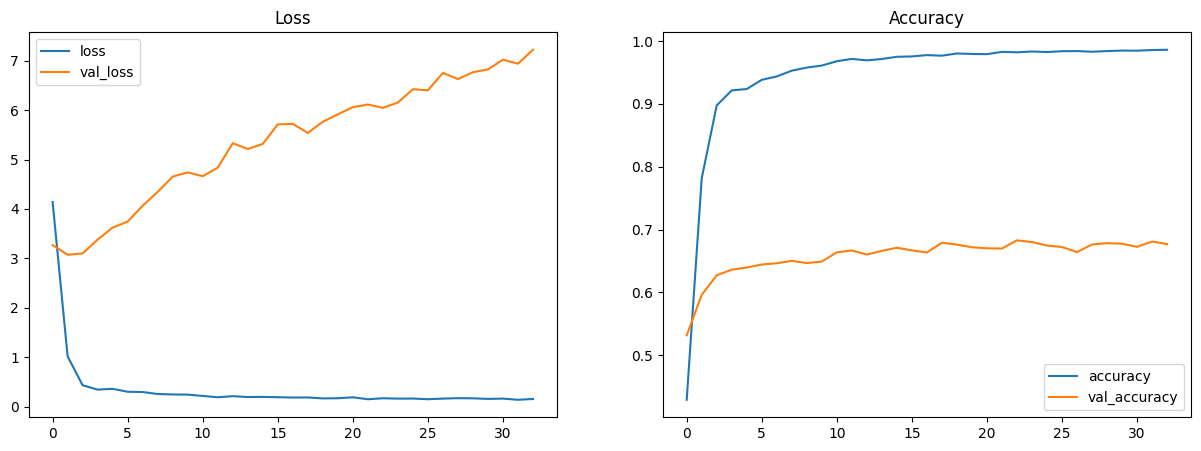

161/161 [==============================] - 4s 24ms/step - loss: 6.8573 - accuracy: 0.6856
Evaluation results: [loss, accuracy] [6.857296943664551, 0.6855529546737671]


In [19]:
# Evaluate and Save model
learning_rate = 0.0001
evaluate_save_model(model,training_results,test_data,execution_time, learning_rate, batch_size, epochs, optimizer)

## Display predictions

161/161 [==============================] - 5s 28ms/step


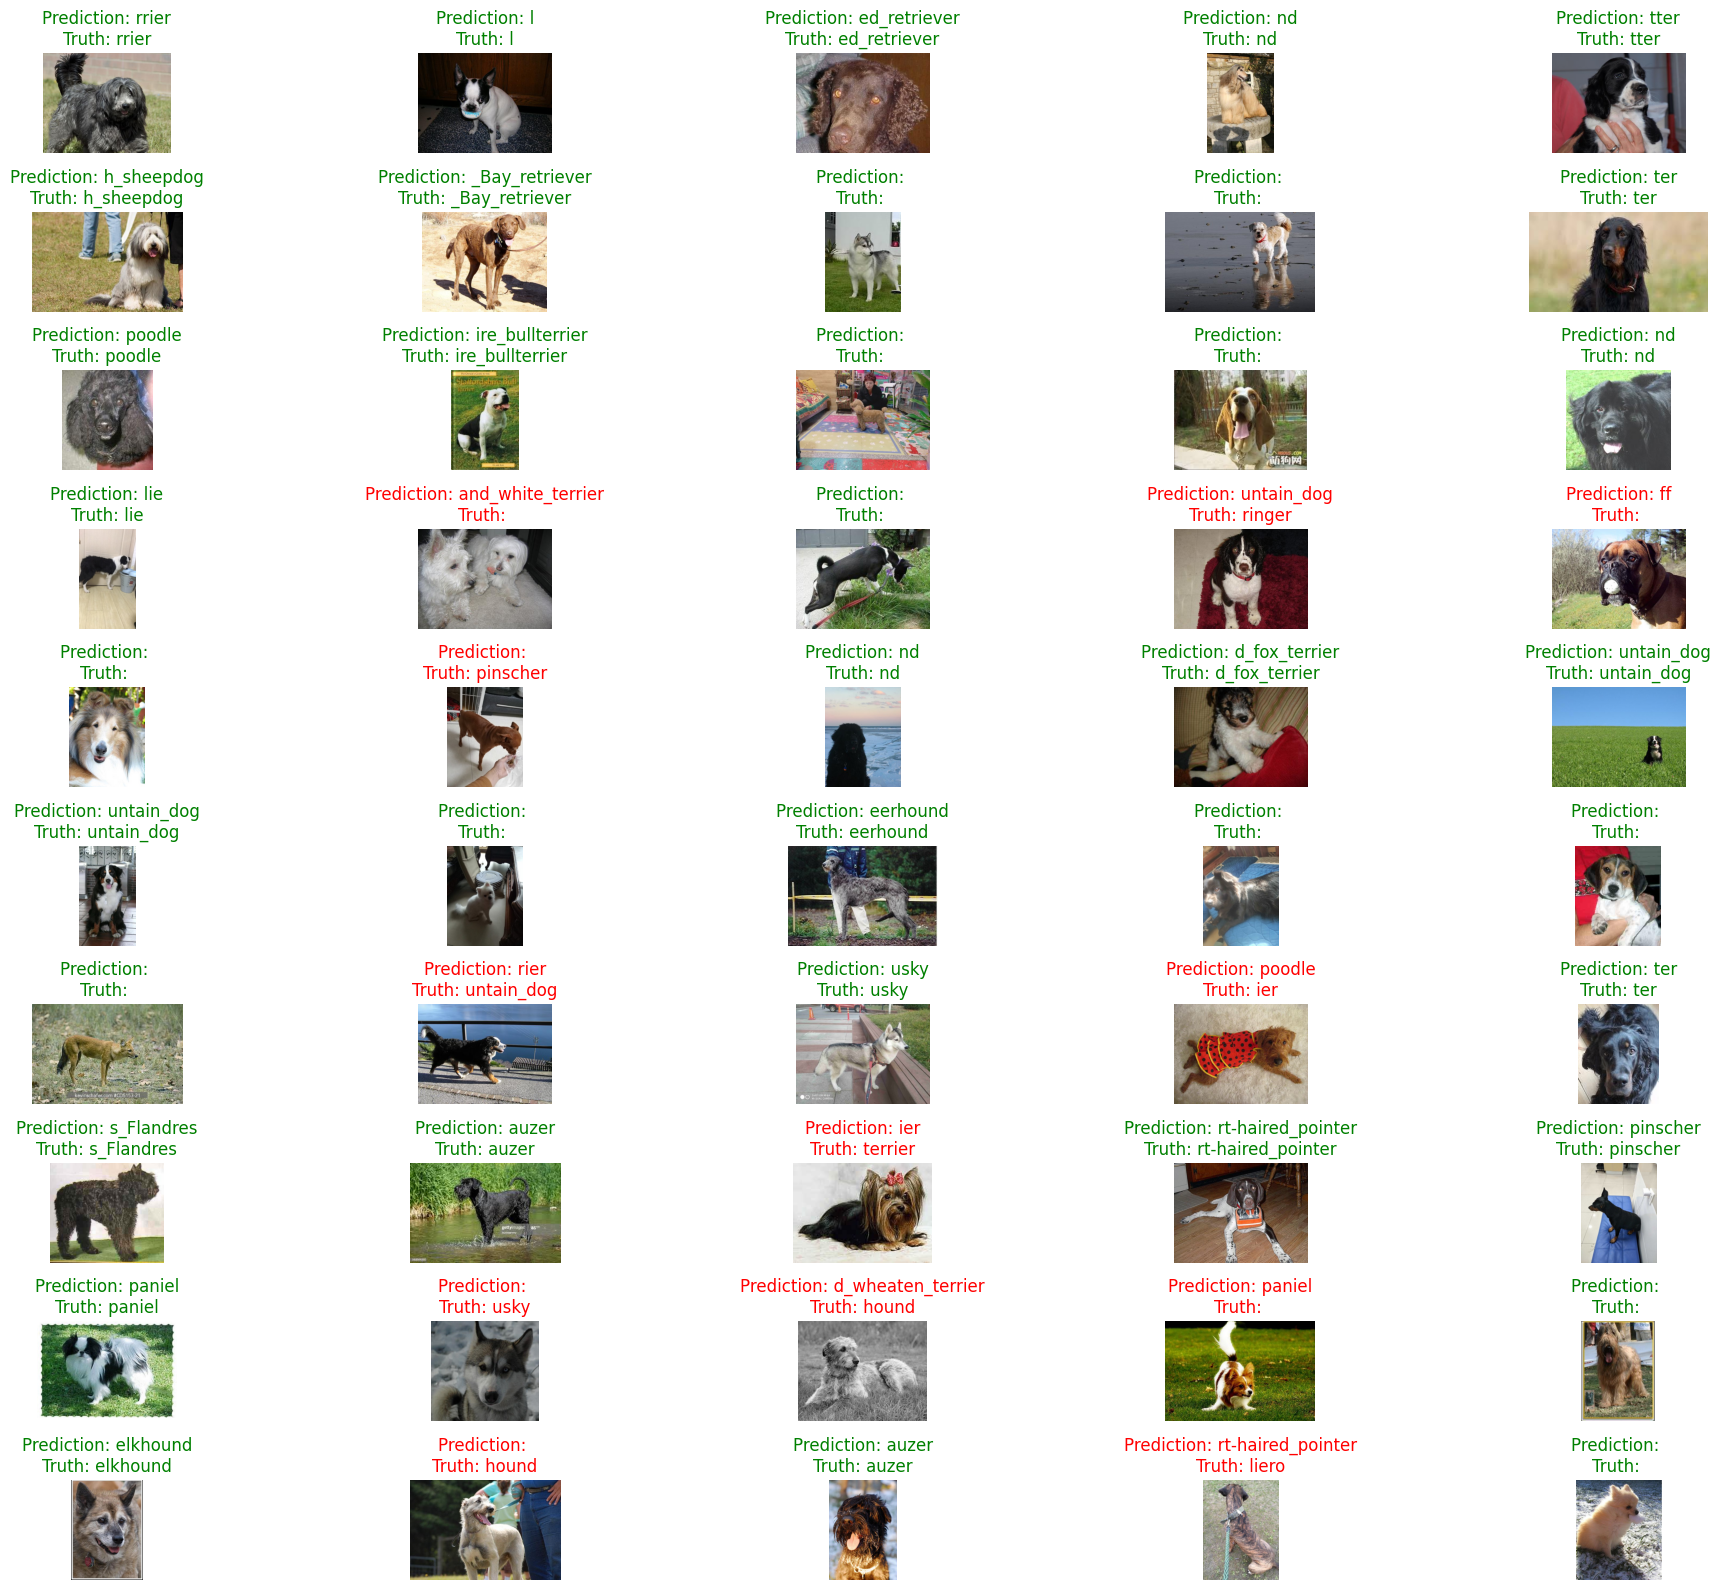

# of true predictions:  38
# of false predictions:  12


In [23]:
# load best model with best weights
prediction_model = tf.keras.models.load_model('./SavedModels/sub500_ResNet50V2_DataAug.hdf5', compile=False)
prediction_model.compile()
checkpoint_path = './Checkpoints/checkpoint_ResNet50V2DataAug'
prediction_model.load_weights(checkpoint_path)

# make predictions
test_predictions = prediction_model.predict(test_data)

# Load Test images
test_x_display = []
for path in test_x:
    path = path.replace("/", "\\")
    # read image
    image = cv2.imread(path)
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Train x
    test_x_display.append(image)
# Convert to numpy array
test_x_display = np.asarray(test_x_display, dtype=object)

# add true and predicted breed for each dog image
# mark it green if prediction is true, otherwise red
# count the total number of true predictions for the first 100 images
true_predict = 0
false_predict = 0
fig = plt.figure(figsize=(20,16))
for i,file in enumerate(test_x_display[:50]):
    axs = fig.add_subplot(10,5,i+1)
    axs.set_aspect('equal')
    predicted_breed = index2label[test_predictions.argmax(axis=1)[i]][10:] # [10:] truncates leading unnecessary letters
    true_breed = test_y[i][10:]
    # color code true/false predictions
    if true_breed == predicted_breed:
      axs.set_title('Prediction: ' + predicted_breed + '\n' + 'Truth: ' + true_breed,color='green')
      true_predict += 1
    else:
      axs.set_title('Prediction: ' + predicted_breed + '\n' + 'Truth: ' + true_breed,color='red')
      false_predict += 1
    plt.imshow(test_x_display[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

print('# of true predictions: ', true_predict)
print('# of false predictions: ', false_predict)

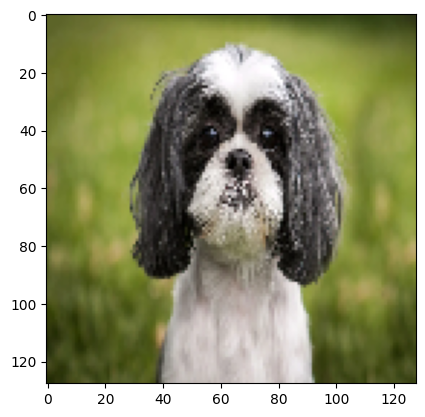

In [22]:
test_img = tf.keras.preprocessing.image.load_img(
    'C:\\Users\Felix\Downloads\Shih-tzu-dog.jpg', target_size=(128, 128)
)
test_img = tf.keras.preprocessing.image.img_to_array(test_img)
# test_img = np.expand_dims(test_img, axis=0)
test_img = test_img/255
plt.imshow(test_img)
test_img = np.asarray([test_img])

In [23]:
# predict on test_img
import pickle
# load best model with best weights
prediction_model = tf.keras.models.load_model('./SavedModels/GOOD_ResNet50V2_DataAug.hdf5', compile=False) #path to model XXX_ResNet50V2DataAug.hdf5
prediction_model.compile()
checkpoint_path = './Checkpoints/GOOD_ResNet50V2DataAug' #path to checkpoint XXX_ResNet50V2DataAug
prediction_model.load_weights(checkpoint_path)

# make predictions
test_predictions = prediction_model.predict(test_img)
with open('label2index.pickle', 'rb') as f:
    class_arr = pickle.load(f)
class_arr = {v: k for k, v in class_arr.items()}
print(class_arr)
print(class_arr[test_predictions.argmax(axis=1)[0]])



1/1 [==============================] - 0s 371ms/step
{0: 'n02085620-Chihuahua', 1: 'n02085782-Japanese_spaniel', 2: 'n02085936-Maltese_dog', 3: 'n02086079-Pekinese', 4: 'n02086240-Shih-Tzu', 5: 'n02086646-Blenheim_spaniel', 6: 'n02086910-papillon', 7: 'n02087046-toy_terrier', 8: 'n02087394-Rhodesian_ridgeback', 9: 'n02088094-Afghan_hound', 10: 'n02088238-basset', 11: 'n02088364-beagle', 12: 'n02088466-bloodhound', 13: 'n02088632-bluetick', 14: 'n02089078-black-and-tan_coonhound', 15: 'n02089867-Walker_hound', 16: 'n02089973-English_foxhound', 17: 'n02090379-redbone', 18: 'n02090622-borzoi', 19: 'n02090721-Irish_wolfhound', 20: 'n02091032-Italian_greyhound', 21: 'n02091134-whippet', 22: 'n02091244-Ibizan_hound', 23: 'n02091467-Norwegian_elkhound', 24: 'n02091635-otterhound', 25: 'n02091831-Saluki', 26: 'n02092002-Scottish_deerhound', 27: 'n02092339-Weimaraner', 28: 'n02093256-Staffordshire_bullterrier', 29: 'n02093428-American_Staffordshire_terrier', 30: 'n02093647-Bedlington_terrier', 

In [ ]:
view_metrics.sort_values(by=['accuracy'],ascending=False).head(10)

,trainable_parameters,execution_time,loss,accuracy,model_size,learning_rate,batch_size,momentum,epochs,optimizer
ResNet50V2_DataAug,"27,497,080",4.41 mins,30.9805,79.40%,142 MB,0.001,32,None,50,Adam
ResNet50V2,"27,497,080",13.14 mins,92.6662,43.68%,142 MB,0.001,32,None,50,Adam
VGG16,"24,276,920",18.02 mins,3.94702,32.46%,97 MB,0.001,32,None,50,SGD
